In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras

/Users/maxwood/opt/miniconda3/envs/deep_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = pathlib.Path('my_data')
img_height = 300
img_width = 300
batch_size = 32

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8183 files belonging to 6 classes.
Using 6547 files for training.


2022-06-14 15:31:08.563289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8183 files belonging to 6 classes.
Using 1636 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['country', 'holiday', 'jazz', 'latin', 'rap', 'rock']


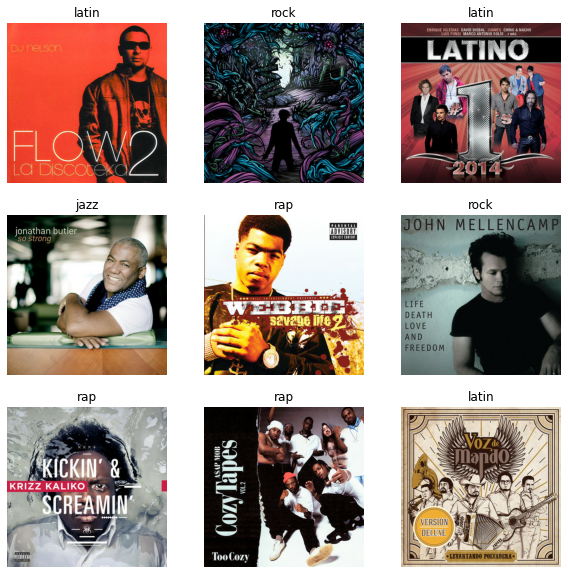

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(7):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Base Model

Start without transfer learning or drop out

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [13]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
205/205 [==============================] - 191s 929ms/step - loss: 1.7762 - accuracy: 0.3053 - val_loss: 1.6211 - val_accuracy: 0.3337
Epoch 2/10
205/205 [==============================] - 197s 957ms/step - loss: 1.5069 - accuracy: 0.4009 - val_loss: 1.5978 - val_accuracy: 0.3557
Epoch 3/10
205/205 [==============================] - 198s 969ms/step - loss: 1.2518 - accuracy: 0.5227 - val_loss: 1.8162 - val_accuracy: 0.3606
Epoch 4/10
205/205 [==============================] - 202s 985ms/step - loss: 0.9239 - accuracy: 0.6464 - val_loss: 3.1323 - val_accuracy: 0.3215
Epoch 5/10
205/205 [==============================] - 201s 979ms/step - loss: 0.6996 - accuracy: 0.7524 - val_loss: 3.1887 - val_accuracy: 0.3258
Epoch 6/10
205/205 [==============================] - 197s 961ms/step - loss: 0.5145 - accuracy: 0.8300 - val_loss: 3.6841 - val_accuracy: 0.3484
Epoch 7/10
205/205 [==============================] - 193s 941ms/step - loss: 0.3545 - accuracy: 0.8850 - val_loss: 3.6980 -

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9

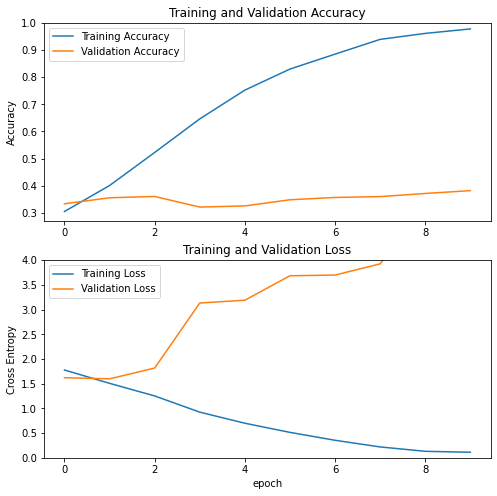

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

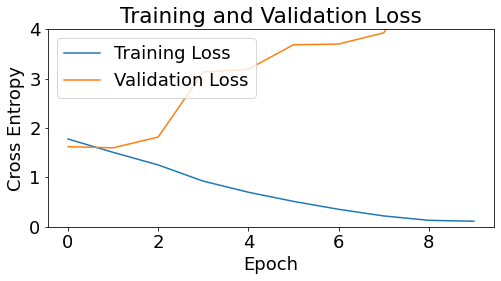

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


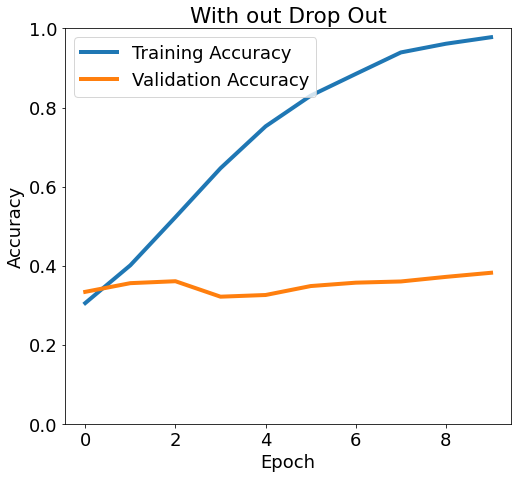

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy',linewidth = 4)
plt.plot(val_acc, label='Validation Accuracy', linewidth = 4)
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('With out Drop Out')

plt.xlabel('Epoch')
plt.show()


In [17]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)

In [18]:
y_prob = model.predict(val_ds)

52/52 [==============================] - 22s 415ms/step


In [19]:
y_predict = y_prob.argmax(axis=-1)

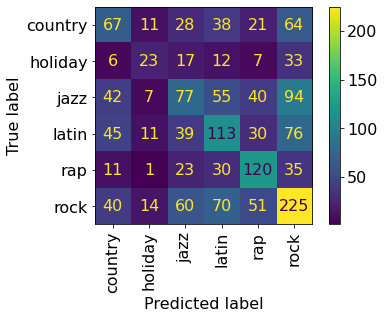

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               display_labels=class_names, xticks_rotation = 'vertical')
#dir(disp)

Hmm Pretty bad :(, looks like we're overfitting a bit. Perhapps dropout can help.

### With Dropout added to our model

In [48]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.80, seed = 123),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [49]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [50]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
205/205 [==============================] - 833s 4s/step - loss: 1.7110 - accuracy: 0.2870 - val_loss: 1.6463 - val_accuracy: 0.3191
Epoch 2/10
205/205 [==============================] - 913s 4s/step - loss: 1.5963 - accuracy: 0.3658 - val_loss: 1.5752 - val_accuracy: 0.3698
Epoch 3/10
205/205 [==============================] - 1117s 5s/step - loss: 1.4881 - accuracy: 0.4106 - val_loss: 1.5569 - val_accuracy: 0.3759
Epoch 4/10
205/205 [==============================] - 838s 4s/step - loss: 1.3722 - accuracy: 0.4611 - val_loss: 1.5645 - val_accuracy: 0.3771
Epoch 5/10
205/205 [==============================] - 969s 5s/step - loss: 1.2610 - accuracy: 0.5137 - val_loss: 1.5816 - val_accuracy: 0.3894
Epoch 6/10
205/205 [==============================] - 650s 3s/step - loss: 1.1330 - accuracy: 0.5648 - val_loss: 1.6318 - val_accuracy: 0.3784
Epoch 7/10
205/205 [==============================] - 618s 3s/step - loss: 1.0144 - accuracy: 0.6168 - val_loss: 1.6464 - val_accuracy: 0.396

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 71, 71, 32)       

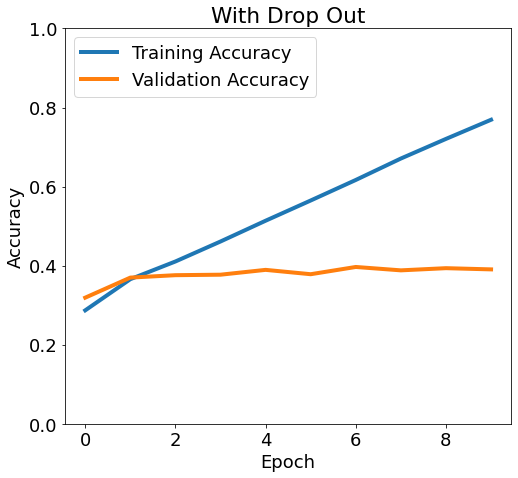

In [114]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy',linewidth = 4)
plt.plot(val_acc, label='Validation Accuracy', linewidth = 4)
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('With Drop Out')

plt.xlabel('Epoch')
plt.show()


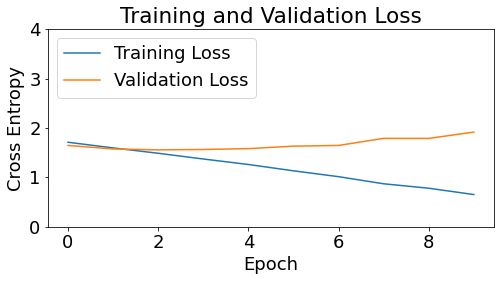

In [86]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


In [ ]:

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')

In [53]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

52/52 [==============================] - 19s 349ms/step


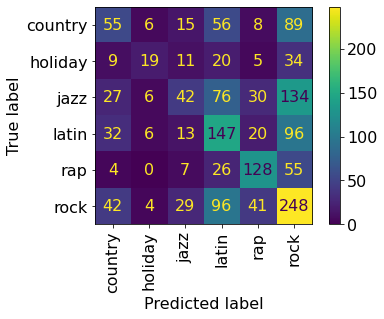

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
plt.rcParams.update({'font.size': 16})
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay.from_predictions(y_actual,y_predict,
                               display_labels=class_names, xticks_rotation = 'vertical')
#dir(disp)
#disp.set_xticklabels(ax.get_xticks(), rotation = 90)
#disp.plot()